# <center> Predicting FPL Player Points via Modeling </center>

Author: Farhan Kassam

In this notebook, we will be taking the cleaned data from the `Data_Cleaning_and_EDA` notebook and create multiple models that will predict the points earned by a player in a given match. The goal is to hopefully have a model that can predict `total_points` better than the FPL `xP` column which will both be compared to the ground truth `total_points`. 

As a reminder, the data is a review of the 22/23 Season and consists of GW 1-24.

Since the target column `total_points` is a continous variable, we will be fitting and evaluating the following models:
- Linear Regression
- Lasso Regression (a Linear Regression model with L1 regularization)
- Random Forest Regressor

In [1]:
import pandas as pd
import numpy as np

np.random.seed(123)

In [2]:
# reading in the clean data and viewing it
df = pd.read_csv('../data/cleaned.csv', index_col=0)
df.head()

,name,position,team,GW,xP,minutes,goals_scored,assists,clean_sheets,saves,...,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,total_points
0,Nathan Redmond,MID,Southampton,1,1.5,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,55,1
1,Junior Stanislas,MID,Bournemouth,1,1.1,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,50,1
2,Armando Broja,FWD,Chelsea,1,2.0,15,0,0,0,0,...,0,0,0,0,0,5.2,0.3,19.0,55,1
3,Fabian Schär,DEF,Newcastle,1,2.4,90,1,0,1,0,...,0,0,0,0,0,66.0,14.6,25.0,45,15
4,Jonny Evans,DEF,Leicester,1,1.9,90,0,0,0,0,...,0,2,0,0,0,14.0,1.3,0.0,45,1


## Preprocessing

From the cleaned dataset, we still have some preprocessing to do before we can fit this to a model. We need to convert the categorical `position` column to a numerical column as it was determined in the EDA notebook that positions have an effect do to the scoring scheme in FPL. Since our dataset is time-dependent in that we are attempting to predict future matches based on past performance, we will split a training and test data based on the GW number where we will train on GW 1-20 and test on the following four gameweeks (21-24 GW). 

Since we are only interested in an individual player's performance, we can drop the `team` column and add it back into our dataframe after the model's predicition. Similarly, we will drop the `name` column as we are assuming that a player's name should not affect their performance but we will need their names and team names later during team selection. Lastly, we need to remove the `xP` column since it is the official FPL's point predicition for the match. 

To summarize, the steps are as follows:

- Convert `position` to numerical via OneHotEncoder
- Split the train and test data based on GW numbers
- Save into a list the `xP`, `GW`, `name`, and `team` of the players
- Drop `xP`, `GW`, `name`, and `team` from the train and test sets 

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [4]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder to the positions column and transform
pos = pd.DataFrame(df['position'])
encoded = ohe.fit_transform(pos)

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded, columns=['DEF', 'FWD', 'GK', 'MID'], dtype=int)

# Add original back in
model_df = pd.concat([df, encoded_df], axis=1)

# Drop position column
model_df = model_df.drop('position', axis=1)

# Show
model_df.head()

,name,team,GW,xP,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,...,red_cards,influence,creativity,threat,value,total_points,DEF,FWD,GK,MID
0,Nathan Redmond,Southampton,1,1.5,1,0,0,0,0,0,...,0,0.0,0.0,0.0,55,1,0,0,0,1
1,Junior Stanislas,Bournemouth,1,1.1,1,0,0,0,0,0,...,0,0.0,0.0,0.0,50,1,0,0,0,1
2,Armando Broja,Chelsea,1,2.0,15,0,0,0,0,0,...,0,5.2,0.3,19.0,55,1,0,1,0,0
3,Fabian Schär,Newcastle,1,2.4,90,1,0,1,0,0,...,0,66.0,14.6,25.0,45,15,1,0,0,0
4,Jonny Evans,Leicester,1,1.9,90,0,0,0,0,0,...,0,14.0,1.3,0.0,45,1,1,0,0,0


Since we are splitting the train and test data based on the GW number, we do not need to import the train-test split from sklearn.

In [5]:
# Train test split

X = model_df.drop('total_points', axis = 1)
y = model_df['total_points']

In [6]:
# Splitting based on GW and then ensuring same shape is used to split target

X_train, X_test = X.loc[X['GW'] < 21], X.loc[X['GW'] >= 21]
y_train, y_test = y[:X_train.shape[0]], y[X_train.shape[0]:]

In [7]:
# Sanity check to make sure shapes of train and test sets are consistent
print(f"X_train Shape: {X_train.shape}\ny_train Shape:{y_train.shape}\n\nX_test Shape:{X_test.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (5916, 23)
y_train Shape:(5916,)

X_test Shape:(1257, 23)
y_test Shape:(1257,)


In [8]:
# saving player names, team, xP, GW number in a list for train and test data

train_names = [n for n in X_train['name']]
train_teams = [t for t in X_train['team']]
train_xP = [x for x in X_train['xP']]
train_GW = [g for g in X_train['GW']]


test_names = [n for n in X_test['name']]
test_teams = [t for t in X_test['team']]
test_xP = [x for x in X_test['xP']]
test_GW = [g for g in X_test['GW']]

In [9]:
# Removing names from training and test data
X_train = X_train.drop(['name', 'team', 'xP', 'GW'], axis = 1)
X_test = X_test.drop(['name', 'team', 'xP', 'GW'], axis = 1)

## Linear Regression Model

We are now ready to fit our first model on the data. We will first be scaling our data and then fitting to a base linear regression model. We will then view and discuss the model's coefficients and score using the r-squared metric.

In [10]:
# Scale data with Standard Scaler

ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [11]:
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, y_train)

LinearRegression()

In [12]:
LR_coefs = pd.DataFrame(data= LR_model.coef_.reshape(1,19), columns=X_train.columns, index = ['coeffs'])
LR_coefs

,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,DEF,FWD,GK,MID
coeffs,0.471161,1.729205,0.905741,0.9356,0.326425,0.277705,-0.098572,-0.380149,-0.176443,-0.378476,-0.14612,0.251833,0.062377,-0.123467,-0.025455,-1.971373e+13,-1.385099e+13,-1.049463e+13,-2.077991e+13


The base model determined that the most important features to predict points are:
- goals_scored with a positive correlation of 1.729
- assists with a positive correlation of 0.905
- clean_sheets with a positive correlation of 0.935

This makes sense since the rules of FPL reward these statistics the most. Interestingly, the positions were the least important in prediction with this model. 

Let's view and interpret the models performance.

R^2 of the Linear Regression for train data: 0.8703524975724928
R^2 of the Linear Regression for test data: 0.8548425633013981


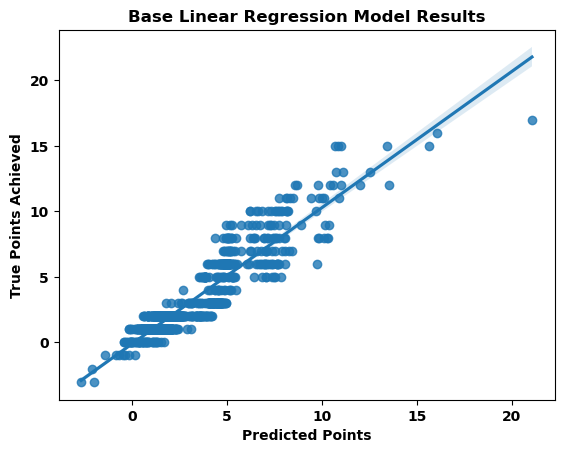

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"R^2 of the Linear Regression for train data: {LR_model.score(X_train_scaled, y_train)}")
print(f"R^2 of the Linear Regression for test data: {LR_model.score(X_test_scaled, y_test)}")

# plotting default linear regression
plt.figure()
sns.regplot(x=LR_model.predict(X_test_scaled), y=y_test)
plt.title('Base Linear Regression Model Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

The base model has a r-squared of 87% in the training data and a 85% in the test data meaning that the model can explain 87% of variance in the points earned for the training data and 85% in the test data.

Although this is a good score, we can attempt to improve the model by penalizing (by shrinking/L1 regularization) features that are not as important in explaining `total_points` via a lasso regression.

# Lasso Regression

For the lasso regression, we will set up a pipeline with three options for scaling the data: mean and standard deviation (standard scaler), on minimum and maximum values (min max scaler), or no scaling. We will also iterate through a set of alpha values which determine the magnitude of the penalty. 

Again, since our data is time-dependent, we will use a time series split to cross validate our models in the training set where there will be 20 splits, each split representing a gameweek in the train set.

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from tempfile import mkdtemp

# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
X = X_train.values
tsc = TimeSeriesSplit(n_splits=20)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', Lasso())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Lasso()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__alpha': [0.001, 0.01, 1, 5, 10]
            }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc.split(X))

fittedgrid = grid.fit(X_train, y_train)

Let's now extract the best parameters for the Lasso regression.

In [15]:
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpbr6r1xb4',
         steps=[('normalise', None), ('model', Lasso(alpha=0.001))])

We can see that the pipeline determined that the best estimator for our data is a Lasso regression with an alpha of 0.001 and no normalization.

Let's check what our model coefficients and scores looked like for each alpha value. To improve interpretability of the coefficients, we will fit the models with a standard scaler. 

In [16]:
# Checking how the model coeffs change with alpha in Lasso
# Recall X_train_scaled and X_test_scaled were previously defined with a standard scaler
coefs = []
train_scores = []
test_scores = []
for a in [0.001, 0.01, 1, 5, 10]:
    LM = Lasso(alpha=a)
    LM.fit(X_train_scaled, y_train)
    train_scores.append(LM.score(X_train_scaled, y_train))
    test_scores.append(LM.score(X_test_scaled, y_test))
    coefs.append(LM.coef_)

In [17]:
LM_coeffs = pd.DataFrame(data=coefs, columns=X_train.columns, index = [0.001, 0.01, 1, 5, 10])
LM_coeffs

,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,DEF,FWD,GK,MID
0.001,0.456239,1.733441,0.905780,0.943292,0.331829,0.275821,-0.096572,-0.378595,-0.174639,-0.379505,-0.145148,0.254052,0.064654,-0.122621,-0.023505,0.145643,-0.059305,-0.038596,0.0
0.010,0.421556,1.674135,0.885096,0.949335,0.276528,0.263026,-0.088540,-0.359359,-0.163808,-0.366805,-0.136841,0.310840,0.046354,-0.100015,-0.011961,0.132949,-0.057103,-0.000000,-0.0
1.000,0.000000,0.346444,0.000000,0.313175,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.874161,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.0
5.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.0
10.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.0


In [18]:
LM_scores = pd.DataFrame(data=[train_scores,test_scores], columns = [0.001, 0.01, 1, 5, 10], index=['Train', 'Test'])
LM_scores

,0.001,0.010,1.000,5.000,10.000
Train,0.870392,0.870062,0.537158,0.000000,0.000000
Test,0.855361,0.854521,0.524473,-0.000084,-0.000084


As the alpha value increases, some of the model coefficients drop to 0 indicating that they are less important features. 

The most important features determined by a lasso with alpha = 1 are:
- goals_scored with a positive correlation of 0.346
- clean_sheets with a positive correlation of 0.313
- influence witha positive correlation of 0.874

This model had a poor r-squared score meaning that it could only explain 53% of the variance in `total_points` for the train set and 52% for the test set.


The coefficients in the optimized model (alpha of 0.001) has a similar distribution of the most important features being:
- goals_scored with a positive correlation of 1.733
- clean_sheets with a positive correlation of 0.943
- influence with a positive correlation of 0.254

In contrast, this model had a much better r-squared value of 87% for the train set and 85% for the test set.

### Optimized Lasso Regression

Let's now fit the hyperparameter optimized lasso regression and intrepret the results.
This means fitting a lasso regression with an alpha of 0.001 with no normalization.

In [19]:
# Fitting the Lasso Regression with the best parameters from grid search

LM = Lasso(alpha=0.001)
LM.fit(X_train, y_train)

Lasso(alpha=0.001)

R^2 of the Lasso Model for train data: 0.8701593166196246
R^2 of the Lasso Model for test data: 0.8553304149783999


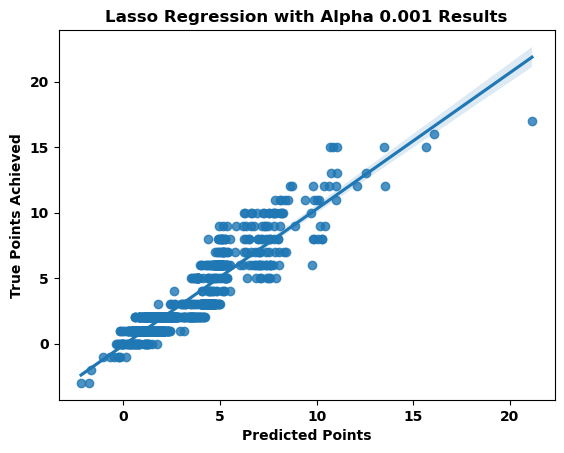

In [20]:
print(f"R^2 of the Lasso Model for train data: {LM.score(X_train, y_train)}")
print(f"R^2 of the Lasso Model for test data: {LM.score(X_test, y_test)}")

# plotting Lasso Regression

plt.figure()
sns.regplot(x=LM.predict(X_test), y=y_test)
plt.title('Lasso Regression with Alpha 0.001 Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

In [21]:
LM_coefs = pd.DataFrame(data=LM.coef_.reshape(1,19), columns=X_train.columns)
LM_coefs

,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,DEF,FWD,GK,MID
0,0.014372,5.356998,3.069435,2.31039,0.348292,6.081139,-1.630524,-0.321643,-2.161076,-1.148421,-2.492737,0.01945,0.004883,-0.007079,-0.001847,0.32688,-0.135687,-0.056577,0.030588


The most important features are:
- goals_scored with a positive correlation of 5.35
- assists with a positive correlation of 3.069
- clean_sheets with a positive correaltion of 2.31
- penalties_saved with a positive correlation of 6.08
- penalties_missed with a negative correlation of -1.63
- own_goals with a negative correlation of -2.161
- yellow_cards with a negative correlation of -1.148
- red_cards with a negative correlation of -2.493

Interestingly, the model coefficients from this model are impressively close to the scoring scheme in FPL. For example, for a goal scored by position the model determined a coefficient of 5.35 and in FPL, 6 points are awarded for GK/DEF, 5 points for MID, and 4 points for FWD. This is similar across the most important features and their weights closely resembling the scoring scheme by FPL.

This also explains the high r-squared values for the train and test set being 87% and 85% respectively.

## Random Forest Regressor

Random forest regressor are a type of ensemble learning where many decision trees are fit on sub-samples of the data and averaging is used to improve predictive accuracy as well as control for over-fitting.

We will first instantiate a regressor with default parameters prior to optimization and interpretation.

In [22]:
from sklearn.ensemble import RandomForestRegressor

# fitting default random forest
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

print(f"Train:{RFR.score(X_train, y_train)}\nTest:{RFR.score(X_test, y_test)}")

Train:0.9949649961838325
Test:0.9672437563402643


The high r-squared in the train data may be indicative of overfitting and can be improved with hyperparameter optimization in the following section. The larger gap between the train and test r-squares compared to the previous models may also be indicating overfitting. 

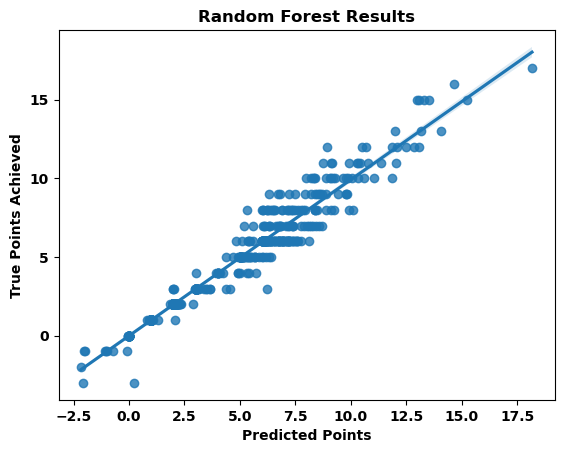

In [23]:
# plotting default random forest

plt.figure()
sns.regplot(x=RFR.predict(X_test), y=y_test)
plt.title('Random Forest Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

### Optimized Random Forest Regressor

To determine the best parameters for our regressor model, we will set up a pipeline with three options for scaling the data: mean and standard deviation (standard scaler), on minimum and maximum values (min max scaler), or no scaling. We will also iterate through a set of estimators which determine the number of decision trees in the forest and a set of max_depth which control the amount of nodes in a decision tree. 

Again, since our data is time-dependent, we will use a time series split to cross validate our models in the training set where there will be 20 splits, each split representing a gameweek in the train set.

In [24]:
# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
X = X_train.values
tsc = TimeSeriesSplit(n_splits=20)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [RandomForestRegressor()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__n_estimators': [i for i in range(50, 100, 50)],
             'model__max_depth': [i for i in range(2, 10, 2)],
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc.split(X))

fittedgrid = grid.fit(X_train, y_train)

In [25]:
# getting best params
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpi5zv6764',
         steps=[('normalise', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=8, n_estimators=50))])

In [26]:
# fitting random forest with parameters from best estimator
RFR = RandomForestRegressor(max_depth = 8, n_estimators=50)

RFR.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50)

Train:0.9742661453189418
Test:0.9619328976562443


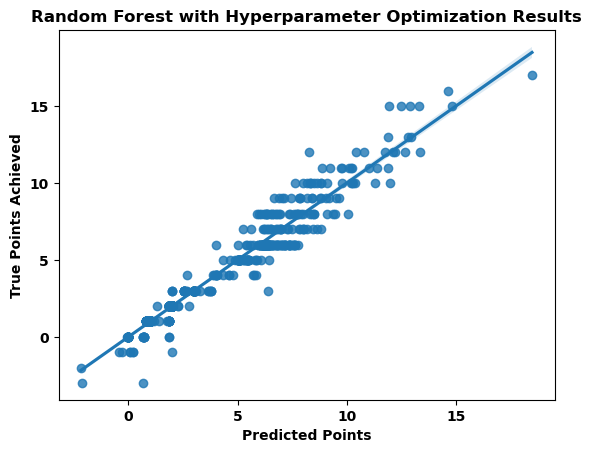

In [27]:
print(f"Train:{RFR.score(X_train_scaled, y_train)}\nTest:{RFR.score(X_test_scaled, y_test)}")

# plotting optimized random forest
plt.figure()
sns.regplot(x=RFR.predict(X_test_scaled), y=y_test)
plt.title('Random Forest with Hyperparameter Optimization Results')
plt.xlabel('Predicted Points')
plt.ylabel('True Points Achieved')
plt.show()

In [28]:
RFR_coefs = pd.DataFrame(data=RFR.feature_importances_.reshape(1,19), columns=X_train.columns)
RFR_coefs

,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,own_goals,yellow_cards,red_cards,influence,creativity,threat,value,DEF,FWD,GK,MID
0,0.013308,0.095374,0.087746,0.205492,0.002792,0.005086,0.000573,0.011593,0.001476,0.013591,0.002083,0.473204,0.008978,0.00622,0.003014,0.042368,0.006848,0.010357,0.009898


The most important features for the random forest model are:
- goals_scored with a positive correlation of 0.095
- assists with a positive correlation of 0.087
- clean_sheets with a positive correlation of 0.205
- influence with a positive correlation of 0.473

These important predictiors in this model more closely resemble the scaled lasso regression with an alpha of 0.001 which was the expected result. 

Since random forest uses multiple decision trees, the improved accuracy between the two models is expected where the random forest is able to explain 97% of the variance in the test data and 96% in the train data. 

# Team Selector Data

Since the best predictive model was the random forest regressor, we will use the predictions from that model to select a team.

We will add back the deleted columns and concatenate them with the predictions from our model. We will then save this dataframe to a csv to select a team in the Team Selector notebook and compare the results between the FPL predictions, my predictions and the actual results.

In [29]:
# creating dataframe of predictions and true results
mypred = RFR.predict(X_test_scaled)
pred_df = pd.DataFrame(data = [test_names, df.loc[df['GW'] >= 21, 'position'].values, test_teams, test_GW, X_test['value'].values, test_xP, mypred, np.array(y_test)], index = ['name', 'position', 'team', 'GW', 'value', 'xP', 'mypred', 'actual_points']).T
pred_df

,name,position,team,GW,value,xP,mypred,actual_points
0,Fabian Schär,DEF,Newcastle,21,51,6.0,7.327581,6
1,Brennan Johnson,FWD,Nott'm Forest,21,56,4.5,5.464833,5
2,Cheick Doucouré,MID,Crystal Palace,21,50,2.0,1.995472,2
3,Alisson Ramses Becker,GK,Liverpool,21,55,4.1,7.012801,9
4,Che Adams,FWD,Southampton,21,63,4.0,1.996585,2
...,...,...,...,...,...,...,...,...
1252,Ethan Pinnock,DEF,Brentford,24,44,3.3,1.99116,2
1253,Vicente Guaita,GK,Crystal Palace,24,44,3.0,2.537948,3
1254,Nick Pope,GK,Newcastle,24,55,0.7,-2.1,-3
1255,Oliver Skipp,MID,Spurs,24,43,0.7,1.995472,2


In [30]:
# saving this dataframe to a csv
pred_df.to_csv('../data/pred_df.csv')